From this point onwards, the report is created inside Jupyter Notebook. 

In this project, I am using collaborative filtering algorithm to predict movie ratings for given user IDs and movie IDs. In this algorithm, the system recommends new products to customers based on customers' collective behavior. The matrix factorization method has emerged as part of the winning algorithm in the Netflix Prize challenge. Alternating Least Squares (ALS) is an algorithm that implements matrix factorization and can be run in a parallelized manner. We will use PySpark's mllib library to run the ALS algorithm [7].

First, we use the spark.read.csv method to read the MovieLens dataset into a dataframe. Notice here that the CSV file is stored inside the gs:// directory, which is the Google Cloud storage directory. inferSchema=True parameter is used to automatically recognize the data type for each column, and header=True parameter is used to assume that the first row of the CSV file is the column names.

In [1]:
df=spark.read.csv("gs://faisna-bucket/ml-latest-small/ratings.csv",inferSchema=True,header=True)
df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



We then convert the dataframe into RDD format. ALS algorithm depends on matrix factorization, which can be computationally demanding for big datasets. Doing the calculations inside RDD format allows the Spark architecture to break up the file into smaller chunks and spread the computation tasks across multiple worker node computers.

In [2]:
rdd_1=df.rdd.map(list)
rdd_1.take(5)

[[1, 1, 4.0, 964982703],
 [1, 3, 4.0, 964981247],
 [1, 6, 4.0, 964982224],
 [1, 47, 5.0, 964983815],
 [1, 50, 5.0, 964982931]]

Next, we remove the timestamp column and use Rating class from the mllib recommendation module to create an RDD called rdd_2 containing a list of user ID, product ID, and rating.

In [4]:
from pyspark.mllib.recommendation import Rating
rdd_2 = rdd_1.map(lambda line: Rating(int(line[0]),int(line[1]),float(line[2])))
rdd_2.take(5)

[Rating(user=1, product=1, rating=4.0),
 Rating(user=1, product=3, rating=4.0),
 Rating(user=1, product=6, rating=4.0),
 Rating(user=1, product=47, rating=5.0),
 Rating(user=1, product=50, rating=5.0)]

We then split the data into training and test data. We use RDD randomsplit method to split 70% of the data into training data and the remaining 30% into test data. We also split the test data into X_test and Y_test. X_test includes the user ID and movie ID data to be fed to our prediction model. Y_test data will be used to compare between the predicted ratings and the actual ratings.

In [6]:
training_data, test_data = rdd_2.randomSplit([0.7,0.3])
X_test,Y_test = test_data.map(lambda x: (x[0],x[1])),test_data.map(lambda x: x[2])

We then train our model with the training data. The rank parameter is the number of features to use (also referred to as the number of latent factors), while the iterations parameter is the number of iterations of ALS to run. ALS typically converges to a reasonable solution in 20 iterations or less [1].

In [7]:
from pyspark.mllib.recommendation import ALS
ALS_model=ALS.train(training_data, rank=3, iterations=20)

After that, we use our model to predict the movie ratings based on the user IDs and movie IDs from the test data.

In [9]:
Y_predict = ALS_model.predictAll(X_test)
Y_predict.take(5)

[Rating(user=140, product=1084, rating=3.566800396802371),
 Rating(user=288, product=1084, rating=3.995976733991183),
 Rating(user=590, product=1084, rating=4.191149211448002),
 Rating(user=414, product=1084, rating=4.5913966030822095),
 Rating(user=372, product=1084, rating=3.31080802692417)]

Now we will convert the results of our predictions into a paired RDD format. Paired RDD is like a dictionary in Python, where the data consists of key and value pairs. We use this paired RDD format so we can join the prediction data and the actual data into a single table.

In [10]:
paired_rdd_1=rdd_2.map(lambda x: ((x[0],x[1]),x[2]))
paired_rdd_1.take(5)

[((1, 1), 4.0), ((1, 3), 4.0), ((1, 6), 4.0), ((1, 47), 5.0), ((1, 50), 5.0)]

In [11]:
paired_rdd_2=Y_predict.map(lambda x: ((x[0],x[1]),x[2]))
paired_rdd_2.take(5)

[((140, 1084), 3.566800396802371),
 ((288, 1084), 3.995976733991183),
 ((590, 1084), 4.191149211448002),
 ((414, 1084), 4.5913966030822095),
 ((372, 1084), 3.31080802692417)]

In [12]:
prediction_data=paired_rdd_1.join(paired_rdd_2)
prediction_data.take(5)

[((1, 3), (4.0, 3.80375597945676)),
 ((1, 333), (5.0, 4.08972698371601)),
 ((1, 552), (4.0, 3.703958185072743)),
 ((1, 648), (3.0, 4.065075685106322)),
 ((1, 919), (5.0, 4.806102787764953))]

We then convert this RDD data into a dataframe format, give each column an appropriate name, and store it in the storage bucket for future analysis. By default, Spark writes data as multiple part files because each partition is saved individually. Here we use the coalesce(1) method to merge data from all partitions into a single partition and save it inside the rating_prediction folder in the storage bucket.

In [21]:
rdd_3=prediction_data.map(lambda x: (x[0][0], x[0][1], x[1][0], x[1][1]))
df_prediction = rdd_3.toDF()
df_prediction=df_prediction.withColumnRenamed('_1','user_id').withColumnRenamed('_2','movie_id').withColumnRenamed('_3','actual_rating').withColumnRenamed('_4','predicted_rating')
df_prediction.show(5)
#df_prediction.coalesce(1).write.format('com.databricks.spark.csv').save('gs://faisna-bucket/rating_prediction')

+-------+--------+-------------+-----------------+
|user_id|movie_id|actual_rating| predicted_rating|
+-------+--------+-------------+-----------------+
|      1|       3|          4.0| 3.80375597945676|
|      1|     333|          5.0| 4.08972698371601|
|      1|     552|          4.0|3.703958185072743|
|      1|     648|          3.0|4.065075685106322|
|      1|     919|          5.0|4.806102787764953|
+-------+--------+-------------+-----------------+
only showing top 5 rows



# 4. Results

## 4.1 Measuring the errors

There are two commonly used methods of calculating the prediction errors: Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). MAE is the average of the absolute differences between predicted and actual values. On the other hand, RMSE is the square root of the average of the square of the differences between predicted and actual values [7].

In [19]:
MAE=prediction_data.map(lambda x: abs(x[1][0]-x[1][1])).mean()
print("The MAE of the model for the test data is: {}".format(MAE))

The MAE of the model for the test data is: 0.7366403387050042


In [42]:
import math
MSE=prediction_data.map(lambda x: (x[1][0]-x[1][1])**2).mean()
RMSE=math.sqrt(MSE)
print("The RMSE of the model for the test data is: {}".format(MSE))

The RMSE of the model for the test data is: 1.0150382455340567


## 4.2 Analyzing the error distribution

MAE and MSE compare the overall difference between predicted and actual ratings, but they do not show how they are different. Here we use a bar graph from matplotlib library to visualize the absolute error distribution. From the bar graph, we can see that only a small portion of the predicted ratings have errors larger than one point.

In [24]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
df_pandas = df_prediction.toPandas()

Text(0.5, 1.0, 'Error Distribution')

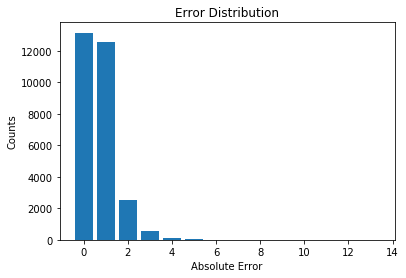

In [41]:
df_pandas['error']=round(abs(df_pandas['actual_rating']-df_pandas['predicted_rating']))
df_pandas.head()
error_counts = Counter(df_pandas['error'])

plt.bar(error_counts.keys(), error_counts.values())
plt.xlabel('Absolute Error')
plt.ylabel('Counts')
plt.title('Error Distribution')

## 4.3 Measuring performance of the recommendation system

To evaluate the performance of the recommendation system, precision and recall are used. These metrics have always been the preferred measures in evaluating movie recommender systems [9]. Precision is calculated as the number of relevant recommendations that the users get. It is defined as the number of correctly recommended items divided by the total number of recommended items. Recall is the ability of the system to recommend as few non-relevant movies as possible. It is defined as the number of correctly recommended items divided by the total number of relevant items. In this project, we define recommended items as movies with predicted rating more than or equal to 3.5 for given user IDs.

In [53]:
TP= len(df_pandas.loc[(df_pandas['predicted_rating'] >= 3.5) & (df_pandas['actual_rating'] >= 3.5)])
total_recommended = len(df_pandas.loc[df_pandas['predicted_rating'] >= 3.5])
precision=TP/total_recommended
print("The precision of the recommendation system is: {}".format(precision))

The precision of the recommendation system is: 0.7896382313532827


In [54]:
total_relevant = len(df_pandas.loc[df_pandas['actual_rating'] >= 3.5])
recall=TP/total_relevant
print("The recall of the recommendation system is: {}".format(recall))

The recall of the recommendation system is: 0.6971608832807571


# 5. Discussion

In the results section, we introduced different metrics to measure the performance of our model: MAE and RMSE. The MAE of the model is 0.7366, which means on average, the predicted ratings miss by 0.7366 from the actual ratings. The RMSE of our model is 1.0150, which is not bad, considering that the Netflix Prize top 2 algorithms achieved RMSE of 0.8914 and 0.8990, respectively [11]. In calculating RMSE, the errors are squared before they are averaged. Thus, it penalizes large errors more than MAE. This means that RMSE is most useful when large errors are particularly undesirable[3].

In addition to calculating the MAE and MSE, we also visualized the error distribution of our model in section 4.2. From the bar graph, we can see that majority of the predicted ratings match with their actual rating, and only a small portion of the predicted ratings have errors larger than one point. This means that even if the predicted rating is wrong, it is highly unlikely that the predicted rating will deviate by more than 1 point.

Finally, we measured the precision and recall of the recommendation system. The precision of our recommendation system is 0.7896, while the recall is 0.6971. Recall compares between true positive and false negative, so it is most useful when false negatives are particularly undesirable. On the other hand, precision compares between true positive and false positive, so it is most useful when false positives are particularly undesirable. For a movie recommendation system, both parameters are important. A low recall may result in a missing opportunity to sell a movie, while low precision may annoy the users with movies they do not like. Our recommendation system does not perform well in these measurements.  As a comparison, a movie recommendation system developed by Subramaniyaswamy et al.[10] performs better with an average precision of 93% and an average recall of 91%. Their model was also based on the collaborative filtering algorithm, but they used additional attributes, such as the users' ages, genders, and occupations.

Despite the results, we have successfully demonstrated how to use different GCP features to analyze big data. During this project, we used (1)cloud shell to ingest the dataset, (2)storage bucket to store the dataset and the results of our recommendation system, (3)Dataproc to run a distributed computing environment, and (4)Pyspark to run Python algorithm inside a Spark environment. We learned how to use these tools from the Distributed Computing and File System, Processing and Analytics, and Cloud Computing modules from our class. 

Pyspark and Dataproc are especially helpful in this project, as the collaborative filtering algorithm depends on matrix factorization, which is very computationally demanding for big datasets. Pyspark also provides mllib library that becomes the fundamental component of our recommendation system. While this project focused on the movie recommendation system, it provides a good understanding of how to set up the GCP environment to solve other machine learning problems as well.

By doing this assignment, we also learned how to solve challenges in managing a data project. When we worked inside the FA21-BL-INFO-I535 folder, the default network and firewall configurations were missing. This is probably due to an inherited security policy. Fortunately, before moving my project into the FA21-BL-INFO-I535 folder, I have run the project in my personal account, so I solved this problem by copying the configurations from my personal GCP account. Another problem occurred during the night of submission when suddenly my project became inaccessible. Half of my report was stored as a Python Notebook inside the project, so I could not access my report. I tried to recover the project by entering my bank account, but it did not work. I then created a new project and rewrite my codes and report from the scratch. This experience reminds me of the importance of creating back-ups in a data project.

# 6. Conclusion

In this project, a movie recommendation system is developed using the concept of collaborative filtering. In the proposed model, user ratings are used to map out other users with similar tastes, and recommendations are made by filtering predicted ratings above a certain threshold. The performance of our model was measured with MAE of 0.7366, RMSE of 1.0150, precision of 0.7896, and recall of 0.6972. In this project, we also demonstrated how to use different Google Platform features that we learned during the class to analyze big data. Pyspark was chosen for its complete machine learning library and its ability to run complex matrix factorization in a distributed computing environment. The result of our prediction is then stored in the storage bucket for future analysis. While our model provides good RMSE, several improvements are needed to get better precision and recall. Some possible improvements are by adding relevant features, such as users' demographics.

# 7. References

[1]: “Collaborative filtering - RDD-based API,” Collaborative Filtering - RDD-based API - Spark 2.2.0 Documentation. [Online]. Available: https://spark.apache.org/docs/2.2.0/mllib-collaborative-filtering.html. [Accessed: 23-Nov-2021]. 

[2]: F. O. Isinkaye, Y. O. Folajimi, and B. A. Ojokoh, “Recommendation systems: Principles, methods and evaluation,” Egyptian Informatics Journal, vol. 16, no. 3, pp. 261–273, 2015. 

[3]: Jj, “Mae and RMSE - which metric is better?,” Medium, 23-Mar-2016. [Online]. Available: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d. [Accessed: 23-Nov-2021]. 

[4]: “Movielens,” GroupLens, 02-Mar-2021. [Online]. Available: https://grouplens.org/datasets/movielens/. [Accessed: 23-Nov-2021]. 

[5]: “Netflix (NFLX) - market capitalization,” CompaniesMarketCap.com - companies ranked by market capitalization. [Online]. Available: https://companiesmarketcap.com/netflix/marketcap/. [Accessed: 23-Nov-2021]. 

[6]: “Netflix prize,” Wikipedia, 10-Oct-2021. [Online]. Available: https://en.wikipedia.org/wiki/Netflix_Prize. [Accessed: 23-Nov-2021]. 

[7]: R. Shankar, Big Data Analytics on Google Cloud. 2020. 

[8]: S. Kumar and samaras, “What is rank, numiteraions and lambda in als.train()?,” Stack Overflow, 01-Oct-1965. [Online]. Available: https://stackoverflow.com/questions/45838557/what-is-rank-numiteraions-and-lambda-in-als-train. [Accessed: 23-Nov-2021]. 

[9]: S. Nair, “PySpark collaborative filtering with ALS,” Medium, 08-Sep-2020. [Online]. Available: https://towardsdatascience.com/build-recommendation-system-with-pyspark-using-alternating-least-squares-als-matrix-factorisation-ebe1ad2e7679. [Accessed: 23-Nov-2021]. 

[10]: V. Subramaniyaswamy, R. Logesh, M. Chandrashekhar, A. Challa, and V. Vijayakumar, “A personalised movie recommendation system based on collaborative filtering,” International Journal of High Performance Computing and Networking, vol. 10, no. 1/2, p. 54, 2017. 

[11]: Xavier Amatriain, “Recommender Systems (Machine Learning Summer School 2014 @ CMU),” SlideShare. [Online]. Available: https://de.slideshare.net/xamat/recommender-systems-machine-learning-summer-school-2014-cmu. [Accessed: 23-Nov-2021]. 